# Lab 01 : Graph Isomorphism Networks - solution

Xu, Hu, Leskovec, Jegelka, How powerful are graph neural networks, 2018   
https://arxiv.org/pdf/1810.00826.pdf

### Xavier Bresson  

<br>
Notebook goals :<br>  
• Implement GIN with DGL <br> 
• Compare performance with node degree, node index, random feature and node positional encoding as Laplacian eigenvectors <br> 


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/06_WL_GNN'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    

In [2]:
# Libraries
import dgl
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from utils import compute_ncut
import time


# Generate CSL dataset

[Graph(num_nodes=7, num_edges=28,
      ndata_schemes={}
      edata_schemes={}), tensor(0)]


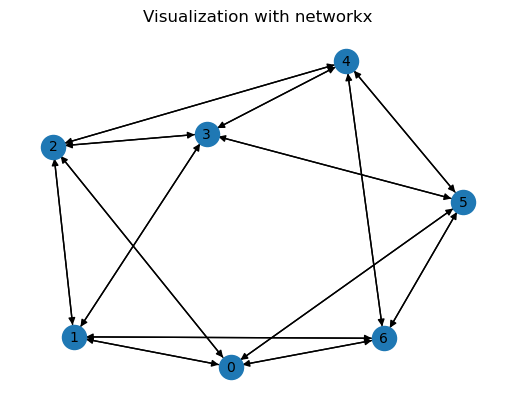

In [3]:
def generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class):
    label_class = 0
    list_graph = []
    # loop over skip values
    for skip_value in list_skip_value:
        # build CSL graph with node indexing in {0,1,...,num_nodes-1}
        list_src = []
        list_dst = []
        for i in range(num_nodes):
            # cycle
            list_src.append(i)
            list_dst.append((i+1)%num_nodes)
            # skip connection
            list_src.append(i)
            list_dst.append((i+skip_value)%num_nodes)
        graph = dgl.graph((list_src, list_dst)) # Build DGL graph
        graph = dgl.to_bidirected(graph) # symmetrize/undirected graph
        list_graph.append([graph, torch.tensor(label_class).long()])
        for _ in range(num_graph_per_class-1): # build CSL graph with random node indexing
            idx_shuffle = torch.randperm(num_nodes).tolist() # random permutation of node indexing
            list_src = [idx_shuffle[i] for i in list_src]
            list_dst = [idx_shuffle[i] for i in list_dst]
            graph = dgl.graph((list_src, list_dst)) # Build DGL graph
            graph = dgl.to_bidirected(graph) # symmetrize/undirected graph
            list_graph.append([graph, torch.tensor(label_class).long()])
        # increment class label
        label_class += 1
    return list_graph


# Generate small CSL graph (for understanding)
num_nodes = 7; list_skip_value = [2]; num_graph_per_class = 1
small_csl_graph = generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class)
print(small_csl_graph[0])
graph = small_csl_graph[0][0]
fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw(graph.to_networkx(), ax=ax, with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()


# Generate train and test datasets 

## Add node feature

In [4]:
# Laplacian eigenvectors as positional encoding
def LapEig_positional_encoding(g, pos_enc_dim):
    Adj = g.adj().to_dense() # Adjacency matrix
    Dn = ( g.in_degrees()** -0.5 ).diag() # Inverse and sqrt of degree matrix
    Lap = torch.eye(g.number_of_nodes()) - Dn.matmul(Adj).matmul(Dn) # Laplacian operator
    EigVal, EigVec = torch.linalg.eig(Lap) # Compute full EVD
    EigVal, EigVec = EigVal.real, EigVec.real # make eig real
    EigVec = EigVec[:, EigVal.argsort()] # sort in increasing order of eigenvalues
    EigVec = EigVec[:,1:pos_enc_dim+1] # select the first non-trivial "pos_enc_dim" eigenvector
    return EigVec

# Add node and edge features to graphs
pos_enc_dim = 6 # dimension of PE
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['degree'] = graph.in_degrees().view(-1, 1).float() # node degree as node feature
        graph.ndata['random'] = torch.rand((graph.number_of_nodes(), pos_enc_dim)) # random features
        graph.ndata['index'] = torch.arange(graph.number_of_nodes()) # node index as node feature
        graph.ndata['pos_enc'] = LapEig_positional_encoding(graph, pos_enc_dim) # node positional encoding as node feature 
    return dataset

# Generate CSL datasets
num_nodes = 41
list_skip_value = [2, 3, 4, 5, 6, 9, 11, 12, 13, 16]
num_graph_per_class = 15
trainset = generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class)
testset = generate_CSL_dataset(num_nodes, list_skip_value, num_graph_per_class)
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
print(trainset[0])


[Graph(num_nodes=41, num_edges=164,
      ndata_schemes={'degree': Scheme(shape=(1,), dtype=torch.float32), 'random': Scheme(shape=(6,), dtype=torch.float32), 'index': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={}), tensor(0)]


# Visualize positional encoding

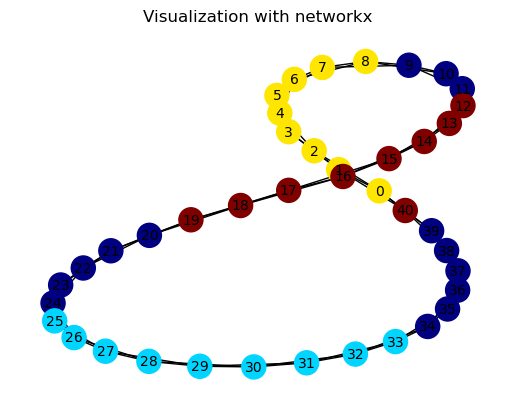

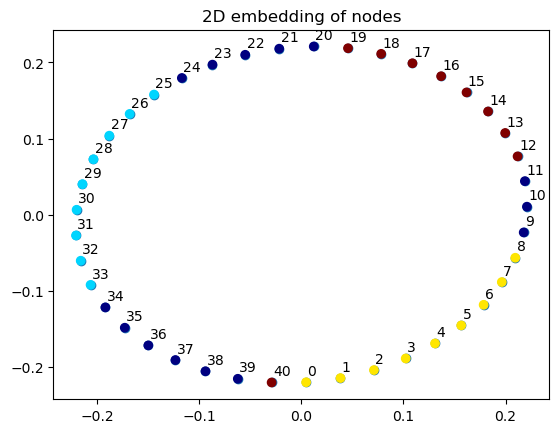

In [5]:
graph = trainset[0][0]

# Visualize graph
fig = plt.figure()
ax = fig.add_subplot(111)
Adj = graph.adj().to_dense()
A_nx = nx.from_numpy_array(Adj.numpy())
C = compute_ncut(Adj.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()

# plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
x = graph.ndata['pos_enc']
ax.scatter(x[:,0], x[:,1])
idx = list(range(graph.number_of_nodes()))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embedding of nodes')
plt.show()


# Define the collate function to prepare a batch of DGL graphs and test it

In [6]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels (here class label)
    return batch_graphs, batch_labels


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['degree']
print('batch_x:',batch_x.size())
batch_pe = batch_graphs.ndata['pos_enc']
print('batch_pe:',batch_pe.size())


Graph(num_nodes=410, num_edges=1640,
      ndata_schemes={'degree': Scheme(shape=(1,), dtype=torch.float32), 'random': Scheme(shape=(6,), dtype=torch.float32), 'index': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={})
tensor([9, 2, 3, 5, 0, 7, 8, 9, 6, 8])
batch_x: torch.Size([410, 1])
batch_pe: torch.Size([410, 6])


# Design the class of Graph Isomorphism Networks with DGL

Node update equation:   
\begin{eqnarray}
h_i^{\ell+1} &=& \textrm{MLP} \left( (1+\varepsilon^{\ell})\ h_i^{\ell} + \sum_{j\sim i} h_j^{\ell} \right)
\end{eqnarray}

In [7]:
# MLP layer for classification
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

        
# class of GatedGCN layer  
class GIN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(GIN_layer, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim, bias=True)
        self.linear2 = nn.Linear(input_dim, output_dim, bias=True)
        # Define a learnable scalar parameter initialized to 0.001
        # You may use "nn.Parameter()"
        # self.eps = ### YOUR CODE HERE, scalar, size=()
        self.eps = nn.Parameter(torch.tensor(0.001)) # scalar, size=()
        
    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges):
        hj = edges.src['h'] 
        return {'hj' : hj}

    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={hj} sent to node dst/i with Step 1
    def reduce_func(self, nodes):
        hj = nodes.mailbox['hj'] # size=(V,|Nj|,d), |Nj|=num_neighbors
        # Compute hi = sum_j hj
        # sum_hj = ### YOUR CODE HERE, size=(V,d)
        sum_hj = torch.sum( hj, dim=1 ) # hi = sum_j hj, size=(V,d)
        return {'sum_hj' : sum_hj} 
    
    def forward(self, g, h):
        g.ndata['h'] = h 
        g.update_all(self.message_func,self.reduce_func) # update the node feature with DGL
        # Compute GIN node update 
        # You may use "nn.Linear()", "torch.relu()"
        # h = ### YOUR CODE HERE, size=(V,d)
        h = (1 + self.eps) * h + g.ndata['sum_hj'] # size=(V,d)
        h = self.linear2(torch.relu(self.linear1(h))) # size=(V,d)
        return h
    
    
class GIN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GIN_net, self).__init__()
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        degree_dim = 1
        self.embedding_h = nn.Linear(degree_dim, hidden_dim) # node degree as node feature
        #self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # random features
        #self.embedding_h = nn.Embedding(num_nodes, hidden_dim) # node index as node feature
        #self.embedding_h = nn.Linear(pos_enc_dim, hidden_dim) # node positional encoding as node feature 
        self.GIN_layers = nn.ModuleList([ GIN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # GIN layers
        for GINlayer in self.GIN_layers:
            h = GINlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.sum_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc


# Instantiate one network (testing)
net_parameters = {}
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
net = GIN_net(net_parameters)
print(net)


GIN_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (GIN_layers): ModuleList(
    (0-3): 4 x GIN_layer(
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
  )
)


In [9]:
def run_one_epoch(net, data_loader, train=True):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['degree'] # node degree as node feature
        #batch_x = batch_graphs.ndata['random'] # random features
        #batch_x = batch_graphs.ndata['index'] # node index as node feature
        #batch_pe = batch_graphs.ndata['pos_enc']; batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        #batch_x = batch_pe # node positional encoding as node feature 
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = net.loss(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += net.accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=10, shuffle=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = len(list_skip_value) # nb of classes
net_parameters['L'] = 4
del net
net = GIN_net(net_parameters)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
for epoch in range(251): 
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, True)
    if not epoch%10:
        with torch.no_grad(): 
            epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, False)
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc))
    

Epoch 0, time 0.5115, train_loss: 12.4722, test_loss: 5.1009
                      train_acc: 0.0600, test_acc: 0.1000
Epoch 10, time 4.5904, train_loss: 2.7200, test_loss: 2.5412
                      train_acc: 0.0800, test_acc: 0.1000
Epoch 20, time 9.0018, train_loss: 2.4407, test_loss: 2.5953
                      train_acc: 0.0600, test_acc: 0.1000
Epoch 30, time 12.8966, train_loss: 2.4109, test_loss: 2.3412
                      train_acc: 0.1067, test_acc: 0.1000
Epoch 40, time 17.8939, train_loss: 2.3887, test_loss: 2.3205
                      train_acc: 0.0667, test_acc: 0.1000
Epoch 50, time 22.7217, train_loss: 2.4470, test_loss: 2.3486
                      train_acc: 0.0667, test_acc: 0.1000
Epoch 60, time 27.4437, train_loss: 2.3652, test_loss: 2.3191
                      train_acc: 0.0600, test_acc: 0.1000
Epoch 70, time 31.9524, train_loss: 2.3292, test_loss: 2.3083
                      train_acc: 0.0467, test_acc: 0.1000
Epoch 80, time 35.8522, train_loss: 2.3551,

In [ ]:
# Results

# node degree :              train_acc: 0.0667, test_acc: 0.1000
# random features :          train_acc: 1.0000, test_acc: 0.2067
# node index :               train_acc: 1.0000, test_acc: 0.2667
# node positional encoding : train_acc: 1.0000, test_acc: 1.0000
